In [12]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl


In [13]:
df = pl.read_parquet(r'D:\20240826_week8\metashape\20241029_products_uav_data\output\extract\polygon_df\plot_10.parquet')
df =df.drop(['distance_xy','angle_rad','vaa_rad','vaa_temp'])
df

Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f32,f64,f32,f32,f32,f32,str
563627.585225,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.086563,"""plot_10""",19.449127,-0.397725,1.470757,4.48,194.578639,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.592477,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085861,"""plot_10""",19.449829,-0.404977,1.470666,4.48,194.314824,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.599728,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085129,"""plot_10""",19.450562,-0.412228,1.470575,4.49,194.051643,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.606979,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.079712,"""plot_10""",19.455978,-0.419479,1.470484,4.49,193.789106,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.614231,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.074341,"""plot_10""",19.461349,-0.426731,1.470393,4.5,193.527221,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563633.869829,5.7130e6,0.006584,0.058976,0.009119,0.140287,0.470458,188.130493,"""plot_10""",19.371399,-44.057329,14.443891,67.32,79.677623,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif"""
563633.848166,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.124802,"""plot_10""",19.37709,-44.035666,14.451416,67.309998,79.694805,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif"""
563633.855418,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.125702,"""plot_10""",19.37619,-44.042918,14.451325,67.309998,79.691903,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif"""


(array([5.191120e+05, 1.320846e+06, 1.132418e+06, 9.117050e+05,
        7.873710e+05, 7.159360e+05, 6.661860e+05, 6.319210e+05,
        6.059220e+05, 5.846050e+05, 5.633860e+05, 5.353750e+05,
        5.033640e+05, 4.639720e+05, 4.201200e+05, 3.746670e+05,
        3.302640e+05, 2.877090e+05, 2.471830e+05, 2.105270e+05,
        1.765900e+05, 1.463810e+05, 1.200570e+05, 9.696500e+04,
        7.812900e+04, 6.186900e+04, 4.941000e+04, 3.909600e+04,
        3.025200e+04, 2.375100e+04, 1.819700e+04, 1.393800e+04,
        1.097800e+04, 8.239000e+03, 6.305000e+03, 4.814000e+03,
        3.719000e+03, 2.833000e+03, 2.165000e+03, 1.704000e+03,
        1.357000e+03, 1.059000e+03, 8.500000e+02, 6.660000e+02,
        5.440000e+02, 4.370000e+02, 3.500000e+02, 2.860000e+02,
        2.140000e+02, 1.770000e+02, 1.590000e+02, 1.320000e+02,
        1.020000e+02, 6.900000e+01, 5.600000e+01, 4.900000e+01,
        4.900000e+01, 3.500000e+01, 2.100000e+01, 3.000000e+01,
        2.200000e+01, 1.400000e+01, 1.10

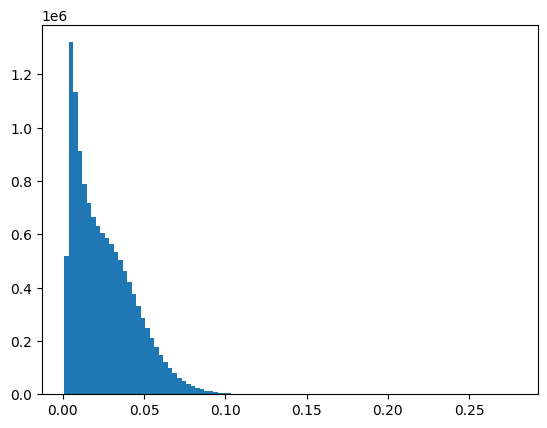

In [14]:
import random
np.random.seed(42)
subset = df.sample(n=100000, with_replacement=True, shuffle=True, seed=42)
plt.hist(df['band1'],bins=100)

In [15]:
df = df.with_columns([
    (pl.col("xcam") - pl.col("Xw")).alias("vx"),
    (pl.col("ycam") - pl.col("Yw")).alias("vy"),
    pl.col("delta_z").alias("vz"),            # already positive
])

df = df.with_columns(
    ((pl.col("vx")**2 + pl.col("vy")**2 + pl.col("vz")**2).sqrt()).alias("v_norm")
)

df = df.with_columns([
    pl.map_batches(["vz", "v_norm"], lambda zs:
           np.degrees(np.arccos(zs[0] / zs[1]))).alias("vza_deg_new"),

    pl.map_batches(["vx", "vy"], lambda xy:
           (np.degrees(np.arctan2(xy[0], xy[1])) % 360)
    ).alias("vaa_deg_new"),
])

df = df.with_columns([
    # Solar Zenith Angle (degrees)
    (90 - pl.col("sunelev")).alias("sza_deg"),

    # View Zenith Angle (degrees)
    pl.col("vza").alias("vza_deg_new"),

    # Relative Azimuth Angle (degrees), wrapped to 0–180°
    (
        ((pl.col("saa") - pl.col("vaa_deg_new")).abs() % 360)              # raw |Δazimuth| ∈ [0, 360)
        .map_elements(                                             # clamp >180° to its supplement
            lambda x: x if x <= 180 else 360 - x,
            return_dtype=pl.Float32
        )
    ).alias("raa_deg"),
])

df



Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path,vx,vy,vz,v_norm,vza_deg_new,vaa_deg_new,sza_deg,raa_deg
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f32,f64,f32,f32,f32,f32,str,f64,f64,f32,f64,f32,f64,f32,f32
563627.585225,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.086563,"""plot_10""",19.449127,-0.397725,1.470757,4.48,194.578639,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.397725,1.470757,19.449127,19.508713,4.48,344.867885,34.929276,165.421356
563627.592477,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085861,"""plot_10""",19.449829,-0.404977,1.470666,4.48,194.314824,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.404977,1.470666,19.449829,19.509554,4.48,344.604069,34.929276,165.685181
563627.599728,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085129,"""plot_10""",19.450562,-0.412228,1.470575,4.49,194.051643,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.412228,1.470575,19.450562,19.51043,4.49,344.340889,34.929276,165.948364
563627.606979,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.079712,"""plot_10""",19.455978,-0.419479,1.470484,4.49,193.789106,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.419479,1.470484,19.455978,19.515978,4.49,344.078351,34.929276,166.210892
563627.614231,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.074341,"""plot_10""",19.461349,-0.426731,1.470393,4.5,193.527221,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.426731,1.470393,19.461349,19.521482,4.5,343.816466,34.929276,166.472778
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563633.869829,5.7130e6,0.006584,0.058976,0.009119,0.140287,0.470458,188.130493,"""plot_10""",19.371399,-44.057329,14.443891,67.32,79.677623,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif""",-44.057329,14.443891,19.371399,50.248635,67.32,288.151374,46.572296,79.67762
563633.848166,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.124802,"""plot_10""",19.37709,-44.035666,14.451416,67.309998,79.694805,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif""",-44.035666,14.451416,19.37709,50.234002,67.309998,288.168556,46.572296,79.694801
563633.855418,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.125702,"""plot_10""",19.37619,-44.042918,14.451325,67.309998,79.691903,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif""",-44.042918,14.451325,19.37619,50.239985,67.309998,288.165654,46.572296,79.691902
